In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from matplotlib.colors import LinearSegmentedColormap
import pickle
import os

In [2]:
from Tools.tools import *
from Plasticity.plasticity import *
from Neuron.neuron import *
from Neuron.neuron_NP import *
from Model.model_CA1 import *
from Analysis.analysis import *

In [3]:
# Load
cd = os.getcwd()
path = os.path.dirname(cd)

with open(path+'//Data_final16_v2.pkl', 'rb') as file:
    # Patterns in input layer
    Data = pickle.load(file)   
    # The number of data
    Datalen = pickle.load(file)    
    # Patterns of granule cells
    Data_DG = pickle.load(file)
    
    # Lengths of each patterns of granule cells
    Data_DG_len = pickle.load(file)
    Data_idx = pickle.load(file) # indices of patterns having proper lengths
    DataX_idx = pickle.load(file) # indices of patterns having proper lengths
    
    # input/output overlap values and indices
    OverI = pickle.load(file)
    OverO = pickle.load(file)
    Pair_idx = pickle.load(file)
    
    # input/output overlap values and indices for inputs having proper lengths
    OverI_v2 = pickle.load(file)
    OverO_v2 = pickle.load(file)
    Pair_idx_v2 = pickle.load(file)
    
with open(path+'//Data_final16_v2-CA3.pkl', 'rb') as file:
    # Filtered by proper length
    Filt_idata = pickle.load(file) # patterns in input layer
    Filt_gdata = pickle.load(file) # patterns of granule cells
    Filt_glen = pickle.load(file) # lengths of each patterns of granule cells
    F_DataLen = pickle.load(file) # the number of data
    
    # Index of CA3 patterns
    Af_py = pickle.load(file) # Pyramidal neurons
    Af_in = pickle.load(file) # Inhibitory neurons
    
    # 
    In_py_list = pickle.load(file)
    In_in_list = pickle.load(file)

In [4]:
class config:
    def __init__(self, seed, pc):
        # the number of neurons
        self.N_I = 16
        self.N_O = self.N_I
    
        self.N_DG = 800 #600
        self.N_DGH = self.N_I #50 
        self.N_DGM = 100 #50
        self.N_DGB = 400 #300
    
        self.N_CA3 = pc[3] #16*12
        self.N_OLM = 1
        self.N_CA1 = 200
        self.N_CA3i = pc[4] # 16*2 #16*3
    
        # weights of each connection
        # From EC
        self.w_EI = 3 # 2
        self.w_ppDG = 2 # 2 # 2.5
        self.w_ppCA3 = 1 # 0.5
        self.w_ppCA1 = 0.5 # 2
        
        # DG
        self.w_IH = 3 # 5
        self.w_IB = 4 # 7.5
        self.w_IM = 3 # 7.5
        self.w_HM = 4 # 4.5
        self.w_MB = 4 # 7.5
        self.w_BDG = 3 # 3
        self.w_HB = 0 # 2.5        
        
        # CA3
        self.w_mf = 2 # 6
        self.w_mfi = 2 # 
        self.w_Rc = 1 # 1.5
    
        self.w_CA33i = 1 #0.5 #2 # 2
        self.w_3iCA3 = 2 # 10 #20 # 7.5 # 2.5
        self.w_3i3i = 0.5 #0.5 #3 #5
        self.w_OLMCA3 = 0 #15 #10
        self.w_NoCA3 = 0.5
        self.w_NoCA3i = 0
        
        # CA1
        self.w_Sc = 0.15 # 2
        self.w_CA1O = 2 # 2
    
        # the number of connections 
        # From EC
        self.c_ppDG = 1 # post_POV
        self.c_ppCA3 = 8 # post_POV
        self.c_ppCA1 = 3
        
        # DG
        self.c_IH = 1
        self.c_IB = self.N_I
        self.c_IM = self.N_I*2//3
        self.c_HM = 1
        self.c_MB = self.N_I
        self.c_BDG = 1
        
        self.c_HB = self.N_I
        
        # CA3
        self.c_mf = pc[0] # pre_POV
        self.c_mfi = pc[1] # pre_POV
        self.c_Rc = self.N_CA3//4 # pre_POV
    
        self.c_CA33i = self.N_CA3i//4 # pre_POV
        self.c_3iCA3 = pc[2] #self.N_CA3i//b # pre_POV
        self.c_3i3i = pc[5] #self.N_CA3i//c # pre_POV
        self.c_OLMCA3 = self.N_OLM
        self.c_NoCA3 = self.N_CA3
        #self.c_NoCA3i = 2
        self.c_Sc =  self.N_CA3 # post_POV
        
        # SEED
        self.seed1 = int(seed[0])
        self.seed2 = int(seed[1])
        self.seed3 = int(seed[2])
        self.seed4 = int(seed[3])
        self.seed5 = int(seed[4])
        self.seed6 = int(seed[5])
        self.seed7 = int(seed[6])
        self.seed8 = int(seed[7])
        self.seedn1 = int(seed[8])
        self.seedn2 = int(seed[9])
        self.seedn3 = int(seed[10])
        self.seedn4 = int(seed[11])
        self.seedn5 = int(seed[12])
        self.seedn6 = int(seed[13])
        self.seedn7 = int(seed[14])
        self.seedn8 = int(seed[15])
        
        # parameter for retricting firing rate
        self.d_I = 10 # 7
        self.d_O = 15
        self.d_DG = 3
        self.d_CA3 = 5
        self.d_CA3i = 1

In [5]:
# init
np.random.seed(100)
SEED = np.zeros((1,17), dtype = int)
for n in range(1):
    SEED[n,:] = np.random.randint(0,300,17)

pc = [30,3,600,2400,120,20]
already_learned = False
learned_weights = [0,0,0,0]

params = config(SEED[0], pc)

In [6]:
network = SNN(params, Neuron, Synapse, learned_weights, already_learned)

In [7]:
with open('Learned weights-global_F2.pkl', 'rb') as file:
    q_ppCA3 = pickle.load(file)   
    q_Rc = pickle.load(file)
    q_CA33i = pickle.load(file)
    q_Sc = pickle.load(file)

In [8]:
engram_idx = [249, 423, 80, 422, 228, 219, 517, 111, 346, 509]

CA3_idx = []
for i, comp in enumerate(engram_idx):
    for j, comp2 in enumerate(Af_py[comp]):
        if comp2 not in CA3_idx:
            CA3_idx += [comp2]
length = len(CA3_idx)

Rc_matrix = np.zeros((length,length))

for i, comp in enumerate(CA3_idx):
    for j, comp2 in enumerate(CA3_idx):
        if q_Rc[comp,comp2] == 0:
            Rc_matrix[i,j] = network.W_Rc[comp,comp2]*0.02
        else:
            Rc_matrix[i,j] = network.W_Rc[comp,comp2]*q_Rc[comp,comp2]

In [9]:
with open('Figure_spiking_encoding_F.pkl', 'rb') as file:
    network = pickle.load(file)
    FT = pickle.load(file)
    Voltage = pickle.load(file)

In [10]:
cmap='gist_earth'

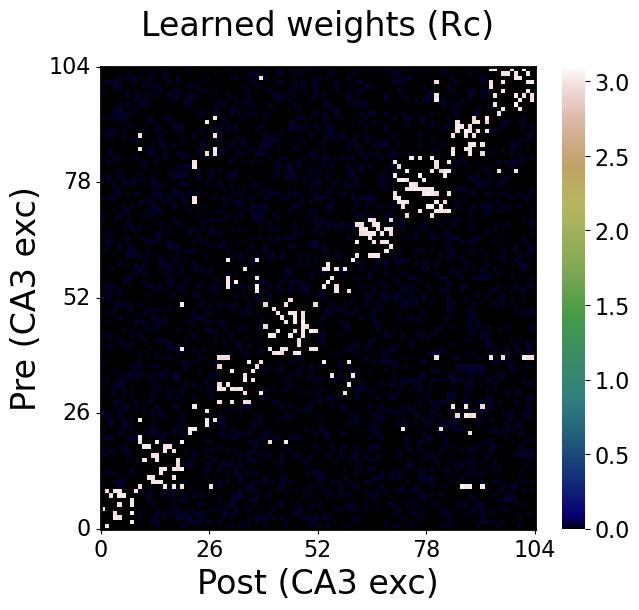

In [11]:
# Heatmap using Seaborn
aspect_ratio = Rc_matrix.shape[1] / Rc_matrix.shape[0]
plt.figure(figsize=(7,6))
fig = sns.heatmap(Rc_matrix, cmap=cmap)
fig.invert_yaxis()
idx_list = [0,26,52,78,104]
fig.set_xticks(idx_list)
fig.set_xticklabels(idx_list, fontsize=16)
plt.xticks(rotation=0)

fig.set_yticks(idx_list)
fig.set_yticklabels(idx_list, fontsize=16)
plt.yticks(rotation=0)

# Customize the colorbar
cbar = fig.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)  # Set the fontsize for the colorbar ticks

for _, spine in fig.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_edgecolor('black') 
    
plt.title('Learned weights (Rc)', fontsize=24, y=1.05)
plt.xlabel('Post (CA3 exc)', fontsize=24)
plt.ylabel('Pre (CA3 exc)', fontsize=24)
#plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('Connection Weights - Rc2.pdf', bbox_inches='tight')
plt.show()

In [12]:
EtoI_matrix = np.zeros((length,params.N_CA3i))
for i, comp in enumerate(CA3_idx):
    for j in range(params.N_CA3i):
        EtoI_matrix[i,j] = network.W_CA33i[comp,j]*q_CA33i[comp,j]

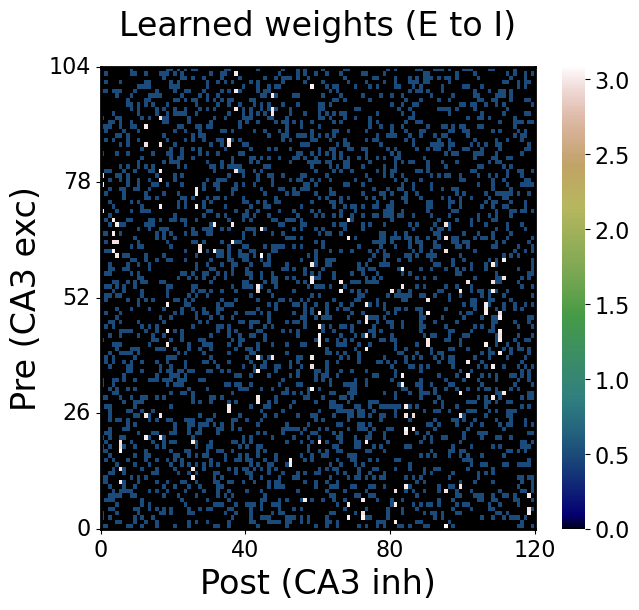

In [13]:
# Heatmap using Seaborn
aspect_ratio = EtoI_matrix.shape[1] / EtoI_matrix.shape[0]
plt.figure(figsize=(7, 6))
fig = sns.heatmap(EtoI_matrix, cmap=cmap)
fig.invert_yaxis()

idx_list = [0,26,52,78,104]
idxi_list = [0,40,80,120]

fig.set_xticks(idxi_list)
fig.set_xticklabels(idxi_list, fontsize=16)
plt.xticks(rotation=0)

fig.set_yticks(idx_list)
fig.set_yticklabels(idx_list, fontsize=16)
plt.yticks(rotation=0)

# Customize the colorbar
cbar = fig.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)  # Set the fontsize for the colorbar ticks

for _, spine in fig.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_edgecolor('black') 
    
plt.title('Learned weights (E to I)', fontsize=24, y=1.05)
plt.xlabel('Post (CA3 inh)', fontsize=24)
plt.ylabel('Pre (CA3 exc)', fontsize=24)
#plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('Connection Weights - EtoI2.pdf', bbox_inches='tight')
plt.show()

In [14]:
ItoE_matrix = np.zeros((params.N_CA3i,length))
for i, comp in enumerate(CA3_idx):
    for j in range(params.N_CA3i):
        ItoE_matrix[j,i] = network.W_3iCA3[j,comp]*network.q_3iCA3[j,comp]

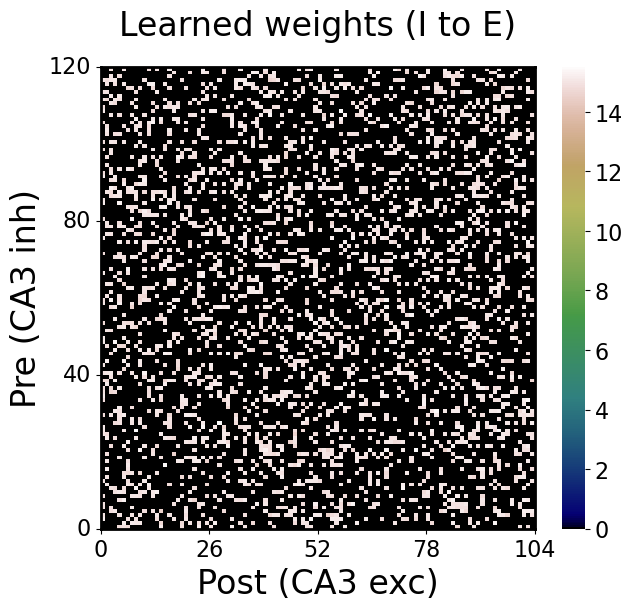

In [15]:
# Heatmap using Seaborn
aspect_ratio = ItoE_matrix.shape[1] / ItoE_matrix.shape[0]
plt.figure(figsize=(7, 6))
fig = sns.heatmap(ItoE_matrix, cmap=cmap)
fig.invert_yaxis()

idx_list = [0,26,52,78,104]
idxi_list = [0,40,80,120]

fig.set_xticks(idx_list)
fig.set_xticklabels(idx_list, fontsize=16)
plt.xticks(rotation=0)

fig.set_yticks(idxi_list)
fig.set_yticklabels(idxi_list, fontsize=16)
plt.yticks(rotation=0)

# Customize the colorbar
cbar = fig.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)  # Set the fontsize for the colorbar ticks

for _, spine in fig.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_edgecolor('black') 
    
plt.title('Learned weights (I to E)', fontsize=24, y=1.05)
plt.xlabel('Post (CA3 exc)', fontsize=24)
plt.ylabel('Pre (CA3 inh)', fontsize=24)
#plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('Connection Weights - ItoE2.pdf', bbox_inches='tight')
plt.show()

In [16]:
PP_matrix = np.zeros((params.N_I,length))
for i, comp in enumerate(CA3_idx):
    for j in range(params.N_I):
        PP_matrix[j,i] = network.W_ppCA3[j,comp]*q_ppCA3[j,comp]

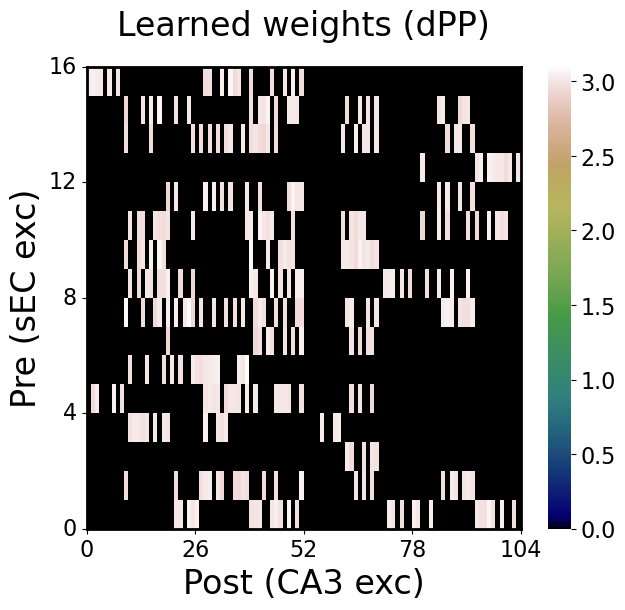

In [17]:
# Heatmap using Seaborn
aspect_ratio = PP_matrix.shape[1] / PP_matrix.shape[0]
plt.figure(figsize=(7, 6))
fig = sns.heatmap(PP_matrix, cmap=cmap)
fig.invert_yaxis()
idx_list = [0,26,52,78,104]
idxi_list = [0,4,8,12,16]
fig.set_xticks(idx_list)
fig.set_xticklabels(idx_list, fontsize=16)
plt.xticks(rotation=0)
fig.set_yticks(idxi_list)
fig.set_yticklabels(idxi_list, fontsize=16)
plt.yticks(rotation=0)

# Customize the colorbar
cbar = fig.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)  # Set the fontsize for the colorbar ticks

for _, spine in fig.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_edgecolor('black') 
plt.title('Learned weights (dPP)', fontsize=24, y=1.05)
plt.xlabel('Post (CA3 exc)', fontsize=24)
plt.ylabel('Pre (sEC exc)', fontsize=24)
#plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('Connection Weights - PP2.pdf', bbox_inches='tight')
plt.show()

In [18]:
Sc_matrix = np.zeros((length, params.N_CA1))
for i, comp in enumerate(CA3_idx):
    for j in range(params.N_CA1):
        Sc_matrix[i,j] = network.W_Sc[comp,j]*q_Sc[comp,j]

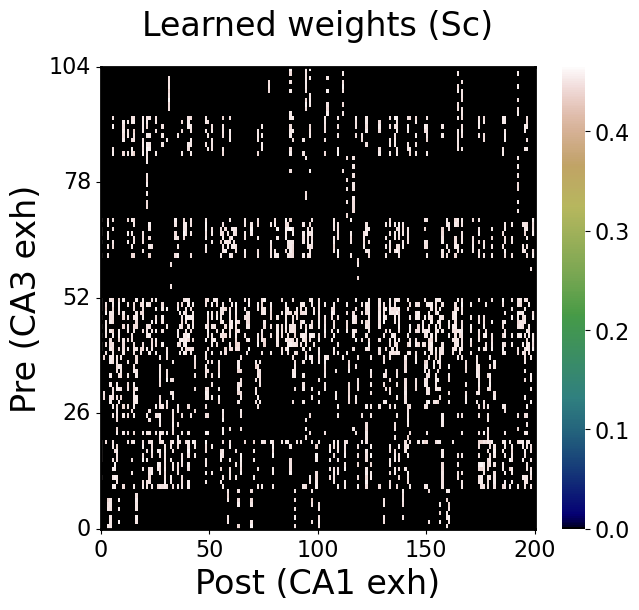

In [19]:
# Heatmap using Seaborn
aspect_ratio = Sc_matrix.shape[1] / Sc_matrix.shape[0]
plt.figure(figsize=(7, 6))
fig = sns.heatmap(Sc_matrix, cmap=cmap)
fig.invert_yaxis()
idx_list = [0,50,100,150,200]
idxi_list = [0,26,52,78,104]
fig.set_xticks(idx_list)
fig.set_xticklabels(idx_list, fontsize=16)
plt.xticks(rotation=0)
fig.set_yticks(idxi_list)
fig.set_yticklabels(idxi_list, fontsize=16)
plt.yticks(rotation=0)

# Customize the colorbar
cbar = fig.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)  # Set the fontsize for the colorbar ticks

for _, spine in fig.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_edgecolor('black') 
plt.title('Learned weights (Sc)', fontsize=24, y=1.05)
plt.xlabel('Post (CA1 exh)', fontsize=24)
plt.ylabel('Pre (CA3 exh)', fontsize=24)
#plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('Connection Weights - Sc2.pdf', bbox_inches='tight')
plt.show()